[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SolanaO/SparkNLP_Study/blob/master/Healthcare_SparkNLP_Equine_Dataset_Study.ipynb)

# Introduction

We use Healthcare Spark NLP pretrained models to identify topics on a set of about 1000 items extracted from querying Google Scholar on the subject of equine colic. This notebook contains all the exploration steps.

# Preliminaries

## Workspace Setup

In [1]:
!pip install -q stylecloud

In [2]:
# Importing the neccessary libraries
import json
import os

import re
import random

import numpy as np
import pandas as pd

from wordcloud import (
    WordCloud,
    ImageColorGenerator,
    STOPWORDS)
import stylecloud

# Libraries and options for graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

# Options to display pandas dataframes
pd.options.display.max_colwidth = None
pd.options.display.float_format = '${:,.3f}'.format

In [3]:
# License keys settings neccessary to work in Healthcare Spark NLP
# as given in the JSL notebooks

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_4811.json to spark_nlp_for_healthcare_spark_ocr_4811 (2).json


In [4]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [5]:
# Importing Spark libraries and modules

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from sparknlp.pretrained import PretrainedPipeline

# Module to display ner results 
from sparknlp_display import NerVisualizer
visualiser = NerVisualizer()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import collect_list

# Settings and parameters for the Spark session
# As included in JSL notebooks

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

# Staring Healthcare Spark NLP session
spark = sparknlp_jsl.start(license_keys['SECRET'], params=params)
spark

Spark NLP Version : 3.4.2
Spark NLP_JSL Version : 3.5.0


## Data Import

In [6]:
# Importing the collection of clean titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/clean_titles.csv
# Save as a spark dataframe
titles_df = spark.createDataFrame(pd.read_csv("clean_titles.csv", index_col=0).reset_index())
# Inspect the data
titles_df.show(4, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                        |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|0    |Prospective study of equine colic risk factors                                                                                              |
|1    | Dietary and other management factors associated with equine colic                                                                          |
|2    |Prospective study of equine colic incidence and mortality                                                                                   |
|3    |Case-control study of the association between various management factors and development of colic i

In [7]:
# Importing the collection of raw titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/raw_titles.csv
# Save as a spark dataframe
raw_titles_df = spark.createDataFrame(pd.read_csv("raw_titles.csv", index_col=0).reset_index())
# Inspect the data
raw_titles_df.show(4, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                        |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------+
|0    |Prospective study of equine colic risk factors                                                                                              |
|1    |[PDF][PDF] Dietary and other management factors associated with equine colic                                                                |
|2    |Prospective study of equine colic incidence and mortality                                                                                   |
|3    |Case-control study of the association between various management factors and development of colic i

In [8]:
# Importing the collection of clean augmented titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/clean_augm_titles.csv
# Save as a pandas dataframe
augm_df = spark.createDataFrame(pd.read_csv('clean_augm_titles.csv', index_col=0).reset_index())
# Inspect the data
augm_df.show(4, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                                                                                                                                                                                                                 |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# Importing the collection of raw augmented titles
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/raw_augm_titles.csv
# Save as a pandas dataframe
raw_augm_df = spark.createDataFrame(pd.read_csv('raw_augm_titles.csv', index_col=0).reset_index())
# Inspect the data
raw_augm_df.show(4, truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|index|text                                                                                                                                                                                                                                                                                                                                      |
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Importing the three sample texts
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/sample_text_1.txt
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/sample_text_2.txt
!wget -q https://raw.githubusercontent.com/SolanaO/SparkNLP_Study/master/data/sample_text_short.txt

In [11]:
# Read the text files
with open('./sample_text_1.txt') as f:
    sample_text_1 = f.read()

with open('./sample_text_2.txt') as f:
    sample_text_2 = f.read()

with open('./sample_text_short.txt') as f:
    sample_text_short = f.read()

## Useful Functions

In [12]:
def display_results(result):
    '''
    Function to extract results from .fullAnnotate() of the
    ner LightPipeline as a pandas dataframe.
    '''
    
    chunks = []
    entities = []
    sentence= []
    begin = []
    end = []

    for n in result[0]['ner_chunk']:
        
        chunks.append(n.result)
        begin.append(n.begin)
        end.append(n.end)
        entities.append(n.metadata['entity']) 
        sentence.append(n.metadata['sentence'])
    

    df_results = pd.DataFrame({'chunk':chunks,
                               'begin': begin, 'end':end,
                               'sent_id':sentence,
                               'entities':entities})

    return df_results

In [13]:
def display_key_phrase_results(result):
    '''
    Function to extract results from .fullAnnotate() of the
    key phrase extract LightPipeline as a pandas dataframe.
    '''
    
    chunks = []
    sentence= []
    entities = []
    docsim = []
    score = []

    for n in result[0]['ner_key_phrases']:
        
        chunks.append(n.result)
        sentence.append(n.metadata['sentence'])
        entities.append(n.metadata['entity']) 
        docsim.append(n.metadata['DocumentSimilarity'])
        score.append(n.metadata['MMRScore'])

    df_results = pd.DataFrame({'key_phrase':chunks, 
                   'sent_id':sentence, 'entity':entities,
                   'docsim': docsim, 'MMRScore': score})

    return df_results.sort_values(by=['sent_id'], ascending=True)

# NER Pretrained Pipelines on Short Text

## Key Pretrained Pipelines

We test several pretrained pipelines on a sample text to gather information on which pipeline would work best for our project.

In [14]:
# Text to analyze
sample_text_short

'Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming. \n'

In [15]:
# Check the clinical_ner pretrained pipeline

pipeline = PretrainedPipeline("ner_clinical_pipeline", "en", "clinical/models")

test_ner_clinical = display_results(pipeline.fullAnnotate(sample_text_short))

ner_clinical_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [16]:
# Check the ner_jsl pretrained pipeline

pipeline = PretrainedPipeline("ner_jsl_pipeline", "en", "clinical/models")

test_ner_jsl = display_results(pipeline.fullAnnotate(sample_text_short))

ner_jsl_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [17]:
# Check the ner_jsl with bert_embeddings pretrained pipeline

pipeline = PretrainedPipeline("ner_jsl_biobert_pipeline", "en", "clinical/models")

test_ner_jsl_biobert = display_results(pipeline.fullAnnotate(sample_text_short))

ner_jsl_biobert_pipeline download started this may take some time.
Approx size to download 403.2 MB
[OK!]


Display the results side by side:

In [18]:
from google.colab import widgets

t = widgets.TabBar(["ner_clinical", "ner_jsl", "ner_bert"])

with t.output_to(0):
    display(test_ner_clinical)

with t.output_to(1):
    display(test_ner_jsl)

with t.output_to(2):
    display(test_ner_jsl_biobert)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,impactions in this most distal segment,39,76,0,PROBLEM
1,ileal impaction,246,260,0,PROBLEM
2,obstruction,335,345,1,PROBLEM
3,ascarids,350,357,1,PROBLEM
4,Parascaris equorum,360,377,1,PROBLEM
5,deworming,432,440,1,TREATMENT


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Disease_Syndrome_Disorder
1,impactions in this most distal segment of the small intestine,39,99,0,Symptom
2,ileal impaction,246,260,0,Disease_Syndrome_Disorder
3,obstruction by ascarids (Parascaris equorum,335,377,1,Symptom
4,3–5 months of age,402,418,1,Age


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,impactions,39,48,0,Symptom
1,distal,63,68,0,Direction
2,small intestine,85,99,0,Internal_organ_or_component
3,ileal impaction,246,260,0,Disease_Syndrome_Disorder
4,obstruction,335,345,1,Symptom
5,ascarids,350,357,1,Disease_Syndrome_Disorder
6,Parascaris equorum,360,377,1,Disease_Syndrome_Disorder
7,3–5 months of age,402,418,1,Age
8,deworming,432,440,1,Procedure


<IPython.core.display.Javascript object>

Although most of the entities are corectly identified, there are chunks such as *coastal Bermuda hay* and *ascarides* that are misinterpreted by `both ner_jsl` and `ner_jsl_biobert` pipelines. We check if there is a pretrained model which recognizes such chunks. This is accomplished via the pretrained model finder as given below.

## Use Pretrained Model Finder

In [19]:
# Find a pretrained model that identifies organisms and geographical locations
ner_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

result = ner_pipeline.annotate("Bermuda hay")
result

ner_model_finder download started this may take some time.
Approx size to download 148.6 MB
[OK!]


{'model_names': ["['ner_medmentions_coarse']"]}

In [20]:
# Check the suggested pipeline

pipeline = PretrainedPipeline("ner_medmentions_coarse_pipeline", "en", "clinical/models")

test_ner_med = display_results(pipeline.fullAnnotate(sample_text_short))
test_ner_med

ner_medmentions_coarse_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Food
1,associated with,23,37,0,Qualitative_Concept
2,impactions,39,48,0,Disease_or_Syndrome
3,distal segment,63,76,0,Body_Location_or_Region
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Spatial_Concept
6,southeastern United States,192,217,0,Geographic_Area
7,prevalence,232,241,0,Quantitative_Concept
8,ileal impaction,246,260,0,Disease_or_Syndrome
9,regional access,275,289,0,Spatial_Concept


# First Version NER Pipeline

We include the two best performing models for our task, as previously identified.

In [21]:
# Prepare data into a format processable by Spark NLP
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Detect sentence boundaries in healthcare texts using DL
sentence_detector = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Split raw text into words pieces in relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Maps sentences and tokens to 200 dim vectors 
word_embeddings = WordEmbeddingsModel \
    .pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("word_embeddings")

# Name entity recognition annotator 
med_ner = MedicalNerModel \
    .pretrained("ner_medmentions_coarse", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "word_embeddings"]) \
    .setOutputCol("ner_med")

# Convert IOB or IOB2 representation to a user friendly one
ner_converter_1 = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_med"]) \
    .setOutputCol("ner_med_chunk")

# Map tokens and sentences to 768 dim vectors using Bert
bert_embeddings = BertEmbeddings \
    .pretrained("biobert_pubmed_base_cased", "en")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("bert_embeddings")

# Named entity recognition annotator based on Bert embeddings
bert_ner = MedicalNerModel \
    .pretrained('ner_jsl_biobert', "en", "clinical/models") \
    .setInputCols(["sentence", "token", "bert_embeddings"]) \
    .setOutputCol("ner_bert")

# Convert IOB or IOB2 representation to a user friendly one
ner_converter_2 = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner_bert"]) \
    .setOutputCol("ner_bert_chunk")

# Annotator to combine the chinks from the two ner models
chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_med_chunk', "ner_bert_chunk")\
    .setOutputCol('ner_chunk')

# Combine all the steps in a pipeline
ner_pipeline = Pipeline(stages = [
    document_assembler,
    sentence_detector,
    tokenizer,
    word_embeddings,
    med_ner,
    ner_converter_1,
    bert_embeddings,
    bert_ner,
    ner_converter_2,
    chunk_merger
    ])

# Create an empty spark dataframe
empty_df = spark.createDataFrame([['']]).toDF("text")

# Create a pipeline model object
ner_pipe_model = ner_pipeline.fit(empty_df)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
biobert_pubmed_base_cased download started this may take some time.
Approximate size to download 386.4 MB
[OK!]
ner_jsl_biobert download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [22]:
# Create a LightPipeline model
light_ner_pipe_model = LightPipeline(ner_pipe_model)

In [23]:
# Print the classes for ner_medmentions_coarse
ner_med_classes = list(MedicalNerModel.pretrained('ner_medmentions_coarse', "en", "clinical/models").getClasses())
print(ner_med_classes)

ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
['O', 'B-Qualitative_Concept', 'B-Mental_Process', 'B-Health_Care_Activity', 'I-Health_Care_Activity', 'B-Professional_or_Occupational_Group', 'B-Population_Group', 'I-Population_Group', 'I-Group', 'B-Pharmacologic_Substance', 'B-Research_Activity', 'B-Medical_Device', 'B-Diagnostic_Procedure', 'B-Molecular_Function', 'B-Spatial_Concept', 'B-Organic_Chemical', 'I-Organic_Chemical', 'B-Amino_Acid,_Peptide,_or_Protein', 'I-Amino_Acid,_Peptide,_or_Protein', 'B-Disease_or_Syndrome', 'I-Disease_or_Syndrome', 'B-Daily_or_Recreational_Activity', 'B-Quantitative_Concept', 'B-Biologic_Function', 'I-Daily_or_Recreational_Activity', 'I-Quantitative_Concept', 'B-Organism_Attribute', 'B-Clinical_Attribute', 'I-Clinical_Attribute', 'B-Pathologic_Function', 'B-Eukaryote', 'I-Eukaryote', 'B-Body_Part,_Organ,_or_Organ_Component', 'B-Anatomical_Structure', 'I-Anatomical_Structure', 'B-Cell_Compone

In [24]:
len(ner_med_classes)

109

In [25]:
# Print the classes for ner_jsl_biobert
ner_bert_classes = list(MedicalNerModel.pretrained('ner_jsl_biobert', "en", "clinical/models").getClasses())
print(ner_bert_classes)

ner_jsl_biobert download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
['O', 'B-Injury_or_Poisoning', 'B-Direction', 'B-Test', 'I-Route', 'B-Admission_Discharge', 'I-Tumor_Finding', 'B-Death_Entity', 'I-Oxygen_Therapy', 'B-Relationship_Status', 'I-Drug_BrandName', 'B-Duration', 'I-Alcohol', 'I-Triglycerides', 'I-Date', 'B-Hyperlipidemia', 'B-Respiration', 'I-Test', 'B-Birth_Entity', 'I-VS_Finding', 'B-Staging', 'B-Age', 'I-Social_History_Header', 'B-Labour_Delivery', 'I-Medical_Device', 'B-Family_History_Header', 'I-Female_Reproductive_Status', 'I-Metastasis', 'B-BMI', 'I-Fetus_NewBorn', 'I-BMI', 'B-Temperature', 'I-Section_Header', 'I-Communicable_Disease', 'I-ImagingFindings', 'I-Psychological_Condition', 'I-Obesity', 'B-Metastasis', 'I-Sexually_Active_or_Sexual_Orientation', 'I-Modifier', 'B-Alcohol', 'I-Temperature', 'I-Vaccine', 'I-Symptom', 'I-Pulse', 'B-Kidney_Disease', 'B-Oncological', 'I-EKG_Findings', 'B-Medical_History_Header', 'I-Relationship_S

In [26]:
len(ner_bert_classes)

170

## Apply NER Pipeline on Text Samples

In [27]:
result_text_short = display_results(light_ner_pipe_model.fullAnnotate(sample_text_short))
result_text_short

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Food
1,associated with,23,37,0,Qualitative_Concept
2,impactions,39,48,0,Disease_or_Syndrome
3,distal segment,63,76,0,Body_Location_or_Region
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Spatial_Concept
6,southeastern United States,192,217,0,Geographic_Area
7,prevalence,232,241,0,Quantitative_Concept
8,ileal impaction,246,260,0,Disease_or_Syndrome
9,regional access,275,289,0,Spatial_Concept


In [28]:
# Create a graphical representation
result_short = light_ner_pipe_model.fullAnnotate(sample_text_short)

visualiser = NerVisualizer()
visualiser.display(result_short[0], 
                   label_col='ner_chunk', 
                   document_col='document', 
                   save_path="display_ner_text_short.html")

Check two larger samples of text using the NER light pipeline model.

In [29]:
# Get results on two larger samples of text

ann_result_1 = light_ner_pipe_model.fullAnnotate(sample_text_1)
result_text_1 = display_results(light_ner_pipe_model.fullAnnotate(sample_text_1))

ann_result_2 = light_ner_pipe_model.fullAnnotate(sample_text_2)
result_text_2 = display_results(light_ner_pipe_model.fullAnnotate(sample_text_2))

In [30]:
from google.colab import widgets

t = widgets.TabBar(["result_text_1", "result_text_2",
                    "viz_text_1", "viz_text_2"])

with t.output_to(0):
    display(result_text_1)

with t.output_to(1):
    display(result_text_2)

# Initialize visualizer
visualiser = NerVisualizer()

with t.output_to(2):
    visualiser.display(ann_result_1[0],
                       label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(ann_result_2[0], 
                       label_col='ner_chunk', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Ileal impaction,0,14,0,Disease_or_Syndrome
1,obstruction of ingesta,33,54,0,Disease_or_Syndrome
2,Coastal Bermuda hay,57,75,1,Food
3,associated with,80,94,1,Qualitative_Concept
4,impactions,96,105,1,Disease_or_Syndrome
5,distal segment,120,133,1,Body_Location_or_Region
6,small intestine,142,156,1,"Body_Part,_Organ,_or_Organ_Component"
7,geographic location,218,236,1,Spatial_Concept
8,southeastern United States,249,274,1,Geographic_Area
9,prevalence,289,298,1,Quantitative_Concept


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk,begin,end,sent_id,entities
0,Gas colic,0,8,0,Sign_or_Symptom
1,tympanic colic,25,38,0,Disease_or_Syndrome
2,gas buildup,58,68,0,Symptom
3,horse's digestive tract,81,103,0,Body_System
4,excessive fermentation,112,133,0,Symptom
5,intestines,146,155,0,"Body_Part,_Organ,_or_Organ_Component"
6,decreased ability to move gas,162,190,0,Symptom
7,diet,244,247,1,Food
8,dietary roughage,280,295,1,Food
9,parasites,305,313,1,Eukaryote


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
result_text_1.nunique()

chunk       39
begin       44
end         44
sent_id      6
entities    22
dtype: int64

In [32]:
# Preview the chunks for the first sentence in sample_text_1
result_text_1[result_text_1.sent_id == '1']

,chunk,begin,end,sent_id,entities
2,Coastal Bermuda hay,57,75,1,Food
3,associated with,80,94,1,Qualitative_Concept
4,impactions,96,105,1,Disease_or_Syndrome
5,distal segment,120,133,1,Body_Location_or_Region
6,small intestine,142,156,1,"Body_Part,_Organ,_or_Organ_Component"
7,geographic location,218,236,1,Spatial_Concept
8,southeastern United States,249,274,1,Geographic_Area
9,prevalence,289,298,1,Quantitative_Concept
10,ileal impaction,303,317,1,Disease_or_Syndrome
11,regional access,332,346,1,Spatial_Concept


# Chunk Key Phrase Extraction Pipeline

Get key phrases from NER chunks with ChunkKeyPhraseExtraction annotator using the default model `sbert_jsl_medium_uncased`. We achieve this by adding an extra step to the `ner_pipeline`.

In [33]:
# Key Phrase Extraction model
ner_key_phrase_extractor = ChunkKeyPhraseExtraction \
    .pretrained()\
    .setTopN(1) \
    .setDocumentLevelProcessing(False) \
    .setDivergence(.4)\
    .setInputCols(["sentence", "ner_med_chunk"])\
    .setOutputCol("ner_key_phrases")

# Combine all stages in a pipeline
key_phrase_pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector, 
    tokenizer, 
    word_embeddings, 
    med_ner, 
    ner_converter_1, 
    ner_key_phrase_extractor
])

sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]


In [34]:
# Create a key phrase pipeline model object
key_phrase_pipe_model = key_phrase_pipeline.fit(empty_df)

In [35]:
# Create a LightPipeline model
light_key_phrase_pipe_model = LightPipeline(key_phrase_pipe_model)

## ChunkKeyPhraseExtractor on Text Samples - Working with Sentences

In [36]:
# Recall the short text
sample_text_short

'Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming. \n'

In [37]:
# Check the output on the short text
key_text_short = light_key_phrase_pipe_model.fullAnnotate(sample_text_short)
display_key_phrase_results(key_text_short)

,key_phrase,sent_id,entity,docsim,MMRScore
0,Coastal Bermuda hay,0,Food,0.64069515297751,0.3844171070618688
1,ascarids,1,Eukaryote,0.556085065622471,0.3336510526315837


In [38]:
# Take a look at text_1
sample_text_1

'Ileal impaction can be caused by obstruction of ingesta. Coastal Bermuda hay is associated with impactions in this most distal segment of the small intestine, although it is difficult to separate this risk factor from geographic location, since the southeastern United States has a higher prevalence of ileal impaction and also has regional access to coastal Bermuda hay. Other causes can be obstruction by ascarids (Parascaris equorum), usually occurring at 3–5 months of age right after deworming, and tapeworms (Anoplocephala perfoliata), which have been associated with up to 81% of ileal impactions. Although most ileal impactions will sometimes pass without intervention, those present for 8–12 hours will cause fluid to back up, leading to gastric reflux, which is seen in approximately 50% of horses that require surgical intervention. Those impactions that are unresponsive to medical management, which includes IV fluids and removal of reflux, may be treated using a single injection into 

In [39]:
# Take a look at text_2
sample_text_2

"Gas colic, also known as tympanic colic, is the result of gas buildup within the horse's digestive tract due to excessive fermentation within the intestines or a decreased ability to move gas through it. It is usually the result of a change in diet, but can also occur due to low dietary roughage levels, parasites (22% of spasmodic colics are associated with tapeworms), and anthelminthic administration. This gas buildup causes distention and increases pressure in the intestines, causing pain. Additionally, it usually causes an increase in peristaltic waves, which can lead to painful spasms of the intestine, producing subsequent spasmodic colic. The clinical signs of these forms of colic are generally mild, transient, and respond well to spasmolytic medications, such as buscopan, and analgesics. Gas colics usually self-correct, but there is the risk of subsequent torsion (volvulus) or displacement of the bowel due to gas distention, which causes this affected piece of bowel to rise upwa

In [40]:
# Get results on the two larger samples of text

ann_keys_result_1 = light_key_phrase_pipe_model.fullAnnotate(sample_text_1)
keys_result_1 = display_key_phrase_results(ann_keys_result_1)

ann_keys_result_2 = light_key_phrase_pipe_model.fullAnnotate(sample_text_2)
keys_result_2 = display_key_phrase_results(ann_keys_result_2)

In [41]:
# Show the results side by side

from google.colab import widgets

t = widgets.TabBar(["key_phrases_1", "key_phrases_2"])

with t.output_to(0):
    display(keys_result_1)

with t.output_to(1):
    display(keys_result_2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,key_phrase,sent_id,entity,docsim,MMRScore
0,obstruction of ingesta,0,Disease_or_Syndrome,0.8601838181268537,0.5161103113844926
2,Coastal Bermuda hay,1,Food,0.6406951859248142,0.38441712683025214
1,ileal impactions,2,Disease_or_Syndrome,0.683271100867084,0.40996267681070286
5,ileal impactions,3,Disease_or_Syndrome,0.46044851578485296,0.2762691204488599
3,injection,4,Therapeutic_or_Preventive_Procedure,0.5601760597671557,0.33610564921593145
4,impaction,5,Injury_or_Poisoning,0.5078789099812953,0.30472735809755397


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,key_phrase,sent_id,entity,docsim,MMRScore
0,Gas colic,0,Sign_or_Symptom,0.6719723482452169,0.40318342496819937
4,parasites,1,Eukaryote,0.6439099802238383,0.3863460034863132
1,pain,2,Sign_or_Symptom,0.6578763542243885,0.39472582821962765
2,spasmodic colic,3,Disease_or_Syndrome,0.651522093462684,0.39091327161110756
3,clinical signs,4,Sign_or_Symptom,0.6447466903683582,0.3868480295929739
5,Gas colics,5,Sign_or_Symptom,0.6424747915887731,0.38548489027105654


<IPython.core.display.Javascript object>

## ChunkKeyPhraseExtractor on Augmented Titles - Sentence Level

In [42]:
# Apply the pipeline to the augumented titles Spark dataframe
augm_results = key_phrase_pipeline.fit(empty_df).transform(augm_df).cache()

# Print the structure of the output
# augm_results.printSchema()

In [43]:
# Display the results
augm = augm_results.select('index', 'text', 'ner_key_phrases')
results_pds = augm \
        .select(augm.index, augm.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(augm.index, augm.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

In [44]:
results_pds.show(10)

+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|index|                text|          key_phrase|               label|DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|    0|Prospective study...|equine colic risk...| Disease_or_Syndrome|0.8871193981976674|  0.532271660069175|       0|
|    0|Prospective study...|               Farms|Professional_or_O...|0.5162123477116849|0.30972742093447236|       2|
|    0|Prospective study...|         horse farms| Manufactured_Object| 0.513297656408337|  0.307978606082972|       1|
|    1| Dietary and othe...|        equine colic| Disease_or_Syndrome|0.8211863865328372| 0.4927118514983114|       0|
|    1| Dietary and othe...|        Equine colic| Disease_or_Syndrome|0.7414624510260274| 0.4448774882934588|       1|
|    1| Dietary and othe...|              horses

## Chunk Key Phrase Extraction - Document Level 

Redo the above analysis, but extracting the key phrases at the document level.

In [45]:
# Set the option on document processing to true 
ner_key_phrase_extractor = ChunkKeyPhraseExtraction \
    .pretrained()\
    .setTopN(1) \
    .setDocumentLevelProcessing(True) \
    .setDivergence(.4)\
    .setInputCols(["sentence", "ner_med_chunk"])\
    .setOutputCol("ner_key_phrases")

doc_phrase_pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector, 
    tokenizer, 
    word_embeddings, 
    med_ner, 
    ner_converter_1, 
    ner_key_phrase_extractor
])

sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]


In [46]:
# Apply the pipeline to the augumented titles Spark dataframe
doc_results = doc_phrase_pipeline.fit(empty_df).transform(augm_df).cache()

In [47]:
# Display the results
doc = doc_results.select('index', 'text', 'ner_key_phrases')
doc_results_pds = doc \
        .select(doc.index, doc.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(doc.index, doc.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

In [48]:
doc_results_pds.show(4)

+-----+--------------------+------------+-------------------+-------------------+-------------------+--------+
|index|                text|  key_phrase|              label| DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+------------+-------------------+-------------------+-------------------+--------+
|    0|Prospective study...| horse farms|Manufactured_Object| 0.5393505409862002|0.32361033745083906|       1|
|    1| Dietary and othe...|equine colic|Disease_or_Syndrome| 0.7005472247814211|    0.4203283515712|       0|
|    2|Prospective study...| horse farms|Manufactured_Object|0.49742477718587785| 0.2984548781710576|       1|
|    3|Case-control stud...|       colic|Disease_or_Syndrome|  0.509548452198009| 0.3057290834673872|       0|
+-----+--------------------+------------+-------------------+-------------------+-------------------+--------+
only showing top 4 rows



In [49]:
# Save as a pandas dataframe
doc_df = doc_results_pds.toPandas()

In [50]:
# Case normalize the key phrases
doc_df.key_phrase = doc_df.key_phrase.str.lower() 

We should filter out equine colic phrase as it is ubiquitous.

In [51]:
# Count the unique values in each column
doc_df.nunique()

index                 908
text                  907
key_phrase            347
label                  36
DocumentSimilarity    906
MMRScore              906
sentence                5
dtype: int64

In [52]:
# There is one duplicated item
doc_df['text'].duplicated().sum()

1

### Items Without Equine Colic in KeyPhrase

In [53]:
# The items that do not contain equine colic in the key phrase
neqcol_df = doc_df[~doc_df['key_phrase'].str.contains('colic')]

In [54]:
# Count the unique values in each column
neqcol_df.nunique()

index                 333
text                  333
key_phrase            267
label                  36
DocumentSimilarity    332
MMRScore              332
sentence                5
dtype: int64

In [55]:
# Distribution on entities
neqcol_df.label.value_counts()

Disease_or_Syndrome                        106
Manufactured_Object                         27
Therapeutic_or_Preventive_Procedure         26
Sign_or_Symptom                             18
Health_Care_Activity                        15
Mammal                                      15
Pathologic_Function                         13
Biologic_Function                            9
Professional_or_Occupational_Group           9
Organic_Chemical                             9
Eukaryote                                    7
Body_Part,_Organ,_or_Organ_Component         6
Injury_or_Poisoning                          6
Research_Activity                            6
Quantitative_Concept                         6
Amino_Acid,_Peptide,_or_Protein              5
Laboratory_Procedure                         5
Organization                                 4
Body_System                                  4
Pharmacologic_Substance                      4
Tissue                                       4
Body_Substanc

In [56]:
neqcol_df[neqcol_df['label'] == 'Disease_or_Syndrome'].head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
20,20,Evaluation of peritoneal fluid lactate as a marker of intestinal ischaemia in equine colic . … Elevated serum glucose has been described in the initial phases of endotoxaemia and glucose values >13.9 mmol/l have been associated with poor prognosis in equine colic. …,intestinal ischaemia,Disease_or_Syndrome,0.7428809481714332,0.44572858661452197,0
33,33,"Interstitial cells of Cajal (ICC) in equine colic: an immunohistochemical study of horses with obstructive disorders of the small and large intestines . Reasons for performing study: The gastrointestinal pacemaker cells, the interstitial cells of Cajal (ICC), have been implicated in several human gastrointestinal dysmotility syndromes. …",gastrointestinal dysmotility syndromes,Disease_or_Syndrome,0.7790428624993324,0.4674257360734287,1
36,36,"Risk factors for equine acute abdominal disease (colic): Results from a multi-center case-control study . … The specific aim of the study, to examine risk factors for equine colic, was not mentioned. A statement that assured confidentiality of all information obtained was also included. Individual …",equine acute abdominal disease,Disease_or_Syndrome,0.6904936264129828,0.4142961923104406,0
37,37,"Survival rates and post‐operative complications after equine colic surgery . Survival rates and postâ•’operative complications after equine colic surgery Page 1 largely functional. The raised IgGJIgG, and IgM/IgG, ratios suggest some local transfer of both IgG, …",postâ•’operative complications,Disease_or_Syndrome,0.7004049272616534,0.42024297305594677,1


In [57]:
neqcol_df[neqcol_df['label'] == 'Manufactured_Object'].head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
0,0,Prospective study of equine colic risk factors . A1 year prospective study was conducted on 31 horse farms to identify risk factors for equine colic. Farms were randomly selected from a list from 2 adjacent counties of Virginia and …,horse farms,Manufactured_Object,0.5393505409862002,0.32361033745083906,1
2,2,"Prospective study of equine colic incidence and mortality . A prospective study of one year was conducted on 31 horse farms to obtain population based estimates of incidence, morbidity and mortality rates of equine colic. Farms with greater …",horse farms,Manufactured_Object,0.49742477718587785,0.2984548781710576,1
218,218,"Internationally recognized equine expert authors comprehensive book on equine colic . Dr. Nat White, a board-certified surgeon, renowned researcher, and the Jean Ellen Shehan Professor and director of Virginia Tech's Marion duPont Scott Equine Medical Center has …",director of virginia tech's marion dupont scott equine medical center has …,Manufactured_Object,0.7076011775416899,0.4245607233955407,1
264,264,"Monitoring acute equine visceral pain with the equine Utrecht University scale for composite pain assessment (EQUUS-COMPASS) and the equine Utrecht University … . This study presents the validation of two recently described pain scales, the Equine Utrecht University Scale for Composite Pain Assessment (EQUUS-COMPASS) and the Equine …",equine utrecht university scale for composite pain assessment,Manufactured_Object,0.8159067974679085,0.489544097933479,1


In [58]:
neqcol_df[neqcol_df['label'] == 'Therapeutic_or_Preventive_Procedure'].head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
26,26,"Laparotomy in equine colic—a report of thirteen clinical cases . A report of 13 unselected clinical cases of colic in horses which were submitted to laparotomy is presented, together with one case of experimental end‐to‐side anastomosis of the ileum …",end‐to‐side anastomosis,Therapeutic_or_Preventive_Procedure,0.5518173331410594,0.3310904130409861,1
56,56,Surgical techniques in equine colic . Emergency equine abdominal surgery is easiest and most efficiently carried out with a team of surgeons. The surgical site should be as protected as possible by the use of sterile …,emergency equine abdominal surgery,Therapeutic_or_Preventive_Procedure,0.6771204352251218,0.40627227727888227,1
68,68,"Providing fluid therapy to equine colic patients. Part 1 . Background: Fluid therapy is a life‐saving measure, which is fundamental in managing horses with colic. It is essential for the clinician to be familiar with the available options when …",fluid therapy,Therapeutic_or_Preventive_Procedure,0.5671993996803598,0.3403196533313034,0
155,155,"Cisapride in the prophylaxis of equine post operative ileus . Cisapride and domperidone were both effective in restoring electrical and mechanical activity, coordination between gastric and small intestinal activity cycles and the stomach to anus …",prophylaxis,Therapeutic_or_Preventive_Procedure,0.6016782532868458,0.3610069663172349,0


In [59]:
neqcol_df[neqcol_df['label'] == 'Sign_or_Symptom'].head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
84,84,Equine colic: seventy-six cases resulting from incarceration of the large colon by the suspensory ligament of the spleen . Incarceration of the large colon by the suspensory ligament of the spleen was diagnosed and surgically corrected on exploratory celiotomy in 76 horses exhibiting abdominal pain. The …,abdominal pain,Sign_or_Symptom,0.6780535739017525,0.40683216050710846,1
184,184,A behaviour-based pain scale for horses with acute colic: scale construction . A validated tool for assessing the severity of acute abdominal pain is needed for the effective management of colic in horses. Two behaviour-based colic pain scales were constructed …,acute abdominal pain,Sign_or_Symptom,0.6190204604240667,0.37141229101303785,1
204,204,"Code red for colic: Decision‐making for acute abdominal pain in the horse . … Decision-making in equine colic cases is based on both clinical signs and results of diagnostic tests, with the main emphasis being placed upon identifying critical/surgical cases. The …",acute abdominal pain,Sign_or_Symptom,0.6338994849361609,0.380339706075038,0
229,229,"Specific causes of colic . Colic is a nonspecific term for abdominal pain. In horses, colic is most often caused by gastrointestinal disease and is often categorized by the affected region and whether the lesion …",abdominal pain,Sign_or_Symptom,0.6106443443142701,0.36638662114745774,1


In [60]:
neqcol_df[neqcol_df['label'] == 'Health_Care_Activity'].head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
11,11,Prognosis in equine colic: a study of individual variables used in case assessment . The individual merit of the use of 43 variables to assess the prognosis of equine colic cases was examined. The following variables revealed highly significant (P<0.001) differences …,prognosis,Health_Care_Activity,0.6000281080099781,0.3600168791117717,1
17,17,Prognosis in equine colic patients using multivariable analysis. . … Multivariable models can also be utilized in clinical prediction; in this study they were used to predict prognosis of equine colic cases. Previous multivariable models formulated for use …,prognosis,Health_Care_Activity,0.6353967052987969,0.3812380383283161,1
49,49,Validation of logistic regression models used in the assessment of prognosis and the need for surgery in equine colic patients . … to evaluate both prognosis and the need for surgery in equine colic patients. The validation study prospectively collected 730 equine colic cases at 16 different locations over a 15-…,prognosis,Health_Care_Activity,0.5558011876916992,0.33348072586635247,0
201,201,Prognosis of Equine Colic by Clinico-Pathological Tests . * Corresponding author: drkumar2000@ gmail. com aboratory tests are more valuable in deciding the eventual prognosis of the colic case than in the diagnosis decision for the surgery. …,prognosis,Health_Care_Activity,0.6075329294374499,0.3645197721471837,2


In [61]:
neqcol_df[neqcol_df['label'] == 'Mammal'].head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
272,272,Observations on the colic motor complex in a pony with a small intestinal obstruction . Characteristic motility patterns were seen throughout the gastrointestinal tract in a pony prepared chronically with electromechanical recording devices after developing a simple …,pony,Mammal,0.500338583668234,0.30020316212994186,0
313,313,"Acute-Phase Proteins of Healthy Horses and Horses Naturally Affected by Colic Syndrome . The purpose of this study was to evaluate and compare the serum proteinogram, identifying and quantifying the acute-phase proteins (APPs) of healthy horses and those naturally …",healthy horses,Mammal,0.4690624504719521,0.28143748146649156,0
318,318,"Trends in the management of horses referred for evaluation of colic: 2004–2017 . The financial crisis of 2008 had effects on veterinary practice, with falling turnovers associated with reluctance of owners to spend money on veterinary care. There were anecdotal …",horses,Mammal,0.3506635021543819,0.21039810965309855,0
376,376,Equine digital biomechanics .,equine,Mammal,0.5807367093418127,0.3484420394509297,0


In [62]:
neqcol_df[neqcol_df['label'] == 'Injury_or_Poisoning'].head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
147,147,Intestinal ischemia-reperfusion injury in horses: pathogenesis and therapeutics. . … Equine colic is a major concern for horse owners and … clinical cases of naturally occurring equine colic is not clear. Thus… to intestinal injury in equine colic. This information may allow …,intestinal ischemia-reperfusion injury,Injury_or_Poisoning,0.7959511862693066,0.47757073073853906,0
187,187,Plasma endotoxin concentrations in experimental and clinical equine subjects . Endotoxin (LPS) was quantitated in experimental subjects and in horses with naturally occurring gastrointestinal strangulation obstruction and/or septicaemic diseases to establish the …,gastrointestinal strangulation obstruction,Injury_or_Poisoning,0.6538553427927574,0.3923132212647806,1
341,341,"Morphologic effects of experimental distention of equine small intestine . … In clinical cases of equine colic, mucosal damage proximal to the obstructed site is more severe in strangulation obstructions than in simple obstructions. '"" Recent clinical data also …",mucosal damage,Injury_or_Poisoning,0.691220251519453,0.4147321673916468,1
449,449,Comparison of ischemic and reperfusion injury of the equine jejunal mucosa: evaluation of three treatments. . … Intestinal ischemic injury accounts for an 80% mortality rate in cases of equine colic involving a strangulation obstruction. This study compared the severity of microscopic mucosal injury …,intestinal ischemic injury,Injury_or_Poisoning,0.7674135366325866,0.46044814027611647,1


In [63]:
test_df = neqcol_df[neqcol_df['label'] == 'Injury_or_Poisoning']
test_df.sort_values(by=['MMRScore'], ascending=False)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
147,147,Intestinal ischemia-reperfusion injury in horses: pathogenesis and therapeutics. . … Equine colic is a major concern for horse owners and … clinical cases of naturally occurring equine colic is not clear. Thus… to intestinal injury in equine colic. This information may allow …,intestinal ischemia-reperfusion injury,Injury_or_Poisoning,0.7959511862693066,0.47757073073853906,0
449,449,Comparison of ischemic and reperfusion injury of the equine jejunal mucosa: evaluation of three treatments. . … Intestinal ischemic injury accounts for an 80% mortality rate in cases of equine colic involving a strangulation obstruction. This study compared the severity of microscopic mucosal injury …,intestinal ischemic injury,Injury_or_Poisoning,0.7674135366325866,0.46044814027611647,1
341,341,"Morphologic effects of experimental distention of equine small intestine . … In clinical cases of equine colic, mucosal damage proximal to the obstructed site is more severe in strangulation obstructions than in simple obstructions. '"" Recent clinical data also …",mucosal damage,Injury_or_Poisoning,0.691220251519453,0.4147321673916468,1
187,187,Plasma endotoxin concentrations in experimental and clinical equine subjects . Endotoxin (LPS) was quantitated in experimental subjects and in horses with naturally occurring gastrointestinal strangulation obstruction and/or septicaemic diseases to establish the …,gastrointestinal strangulation obstruction,Injury_or_Poisoning,0.6538553427927574,0.3923132212647806,1
767,865,"Reperfusion injury in the equine intestine . At the cellular level, reperfusion of ischemic tissue results in rapid generation of oxygen-derived free radicals, which overwhelm endogenous protective antioxidants and induce cell …",reperfusion injury,Injury_or_Poisoning,0.6534996386118574,0.39209979874776,0
650,719,"Cardiac troponin I concentrations in horses with colic . Objective —To determine prevalence of myocardial injury in horses with colic on the basis of high concentrations of cardiac troponin I (cTnI), frequency of cardiac arrhythmias within the …",myocardial injury,Injury_or_Poisoning,0.6288755331637684,0.3773253348918222,1


# Chunk Key Phrase Extraction Pipeline with Common Words Removal

---



At this stage we include a stopwords removal annotator, to drop the words *equine* and *colic* which appear in most of the documents.
We want these words to be removed before the `NerModel`, thus we do not use the option `.setBlackList` which would keep the words for the key extraction phase and remove them only at the very end when the entities are returned.



In [64]:
# Prepare data into a format processable by Spark NLP
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Detect sentence boundaries in healthcare texts using DL
sentence_detector = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Split raw text into words pieces in relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Cleans the query words: equine and colic
words_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("cleanToken")\
      .setCaseSensitive(False)\
      .setStopWords(["equine", "colic"])

# Maps sentences and tokens to 200 dim vectors 
word_embeddings = WordEmbeddingsModel \
    .pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "cleanToken"])\
    .setOutputCol("word_embeddings")

# Name entity recognition annotator 
med_ner = MedicalNerModel \
    .pretrained("ner_medmentions_coarse", "en", "clinical/models") \
    .setInputCols(["sentence", "cleanToken", "word_embeddings"]) \
    .setOutputCol("ner_med")

# Convert IOB or IOB2 representation to a user friendly one
ner_converter= NerConverterInternal() \
    .setInputCols(["sentence", "cleanToken", "ner_med"]) \
    .setOutputCol("ner_chunk")

# Extract key phrases
ner_key_phrase_extractor = ChunkKeyPhraseExtraction \
    .pretrained()\
    .setTopN(1) \
    .setDocumentLevelProcessing(True) \
    .setDivergence(.7)\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("ner_key_phrases")

# Combine all the steps in a pipeline
pipeline = Pipeline(stages = [
    document_assembler,
    sentence_detector,
    tokenizer,
    words_cleaner,
    word_embeddings,
    med_ner,
    ner_converter,
    ner_key_phrase_extractor
    ])

# Create an empty spark dataframe
empty_df = spark.createDataFrame([['']]).toDF("text")

# Create a pipeline model object
pipe_model = pipeline.fit(empty_df)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]


## LightPipeline Results on Text Samples

In [65]:
# Create a LightPipeline model
light_pipe_model = LightPipeline(pipe_model)

In [66]:
result = display_results(light_pipe_model.fullAnnotate(sample_text_short))
result

,chunk,begin,end,sent_id,entities
0,Coastal Bermuda hay,0,18,0,Food
1,associated with,23,37,0,Qualitative_Concept
2,impactions,39,48,0,Disease_or_Syndrome
3,distal segment,63,76,0,Body_Location_or_Region
4,small intestine,85,99,0,"Body_Part,_Organ,_or_Organ_Component"
5,geographic location,161,179,0,Spatial_Concept
6,southeastern United States,192,217,0,Geographic_Area
7,prevalence,232,241,0,Quantitative_Concept
8,ileal impaction,246,260,0,Disease_or_Syndrome
9,regional access,275,289,0,Spatial_Concept


In [67]:
result_2 = display_results(light_pipe_model.fullAnnotate(sample_text_2))
result_2

,chunk,begin,end,sent_id,entities
0,Gas,0,2,0,Substance
1,gas buildup,58,68,0,Chemical
2,horse's digestive tract,81,103,0,Body_System
3,excessive,112,120,0,Qualitative_Concept
4,fermentation,122,133,0,Biologic_Function
5,intestines,146,155,0,"Body_Part,_Organ,_or_Organ_Component"
6,decreased,162,170,0,Quantitative_Concept
7,gas,188,190,0,Chemical
8,diet,244,247,1,Food
9,dietary roughage,280,295,1,Food


By removing the words *equine* and *colic* we miss the *gas colic* chunk. Let's remove the chunk *equine colic* only.

## Pipeline with Common Words Removed on Augmented Titles

In [68]:
# Apply the pipeline to the augumented titles Spark dataframe
results = pipe_model.transform(augm_df).cache()

In [69]:
# Display the results
res = results.select('index', 'text', 'ner_key_phrases')
results_pds = res \
        .select(res.index, res.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(res.index, res.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

In [70]:
results_pds.show(10)

+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|index|                text|          key_phrase|               label| DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|    0|Prospective study...|         horse farms| Manufactured_Object| 0.5393506823715809|0.16180521114103544|       1|
|    1| Dietary and othe...|             disease| Disease_or_Syndrome| 0.5382300798834708| 0.1614690303812438|       1|
|    2|Prospective study...|         horse farms| Manufactured_Object|0.49742477718587785| 0.1492274390855288|       1|
|    3|Case-control stud...|              horses|              Mammal| 0.3811953478424951|0.11435860889695118|       0|
|    4| Practical guide ...|  patient management|Health_Care_Activity|0.27672178400071346|0.08301653849899476|       1|
|    5|A two year, prosp...|epidemiologi

In [71]:
# Save as a pandas dataframe
results_df = results_pds.toPandas()
results_df.head(4)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
0,0,Prospective study of equine colic risk factors . A1 year prospective study was conducted on 31 horse farms to identify risk factors for equine colic. Farms were randomly selected from a list from 2 adjacent counties of Virginia and …,horse farms,Manufactured_Object,0.5393506823715809,0.16180521114103544,1
1,1,"Dietary and other management factors associated with equine colic . … Equine colic is an important cause of disease and death in horses. Relatively few … , and to examine other management factors associated with equine colic. Because horses examined at …",disease,Disease_or_Syndrome,0.5382300798834708,0.1614690303812438,1
2,2,"Prospective study of equine colic incidence and mortality . A prospective study of one year was conducted on 31 horse farms to obtain population based estimates of incidence, morbidity and mortality rates of equine colic. Farms with greater …",horse farms,Manufactured_Object,0.49742477718587785,0.1492274390855288,1
3,3,Case-control study of the association between various management factors and development of colic in horses. Texas Equine Colic Study Group. . The association between various management factors and development of colic was studied in 821 horses treated for colic and 821 control horses treated for noncolic emergencies by …,horses,Mammal,0.3811953478424951,0.11435860889695118,0


In [72]:
# Save the results in a csv file
results_df.to_csv("augm_titles_full.csv")

In [73]:
# Count the unique values in each column
results_df.nunique()

index                 855
text                  854
key_phrase            623
label                  42
DocumentSimilarity    853
MMRScore              853
sentence                6
dtype: int64

In [74]:
# Distribution on entities
results_df.label.value_counts()

Disease_or_Syndrome                        167
Therapeutic_or_Preventive_Procedure         88
Manufactured_Object                         61
Health_Care_Activity                        50
Research_Activity                           38
Sign_or_Symptom                             38
Pathologic_Function                         35
Quantitative_Concept                        35
Organic_Chemical                            34
Mammal                                      27
Biologic_Function                           25
Eukaryote                                   22
Body_Part,_Organ,_or_Organ_Component        21
Professional_or_Occupational_Group          20
Qualitative_Concept                         19
Injury_or_Poisoning                         17
Laboratory_Procedure                        15
Population_Group                            15
Diagnostic_Procedure                        15
Geographic_Area                             15
Pharmacologic_Substance                     13
Amino_Acid,_P

In [75]:
results_pds.filter('label == "Disease_or_Syndrome"').sort(results_pds.MMRScore.desc()).show(10, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------+-------------------+------------------+-------------------+--------+
|index|text                                                                                                                                                                                                                                                                                             |key_phrase                            |label              |DocumentSimilarity|MMRScore           |sentence|
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Pipeline with Common Words Removed on Titles

In [76]:
# Apply the pipeline to the augumented titles Spark dataframe
results_titles = pipe_model.transform(titles_df).cache()

In [77]:
# Display the results in Spark
titles = results_titles.select('index', 'text', 'ner_key_phrases')
results_titles_pds = titles \
        .select(titles.index, titles.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(titles.index, titles.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

In [78]:
results_titles_pds.show(10)

+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|index|                text|          key_phrase|               label| DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+-------------------+-------------------+--------+
|    0|Prospective study...|   Prospective study|   Research_Activity|0.48695922793333063|0.14608777418500554|       0|
|    1| Dietary and othe...|             Dietary|                Food|  0.665735661499414|0.19972070638601172|       0|
|    2|Prospective study...|           mortality|Quantitative_Concept| 0.6337150082517481|0.19011451002999602|       0|
|    3|Case-control stud...|  Case-control study|   Research_Activity|0.43884783052478943|0.13165435438891063|       0|
|    5|A two year, prosp...|  prospective survey|   Research_Activity| 0.4209850191052219|0.12629551075009907|       0|
|    6|Development of a ...|            

In [79]:
results_titles_pds.select('index', 'key_phrase').show(10, truncate=False)

+-----+-----------------------+
|index|key_phrase             |
+-----+-----------------------+
|0    |Prospective study      |
|1    |Dietary                |
|2    |mortality              |
|3    |Case-control study     |
|5    |prospective survey     |
|6    |severity               |
|8    |blood lactate levels   |
|9    |comparative study      |
|10   |operative complications|
|11   |study                  |
+-----+-----------------------+
only showing top 10 rows



In [80]:
# Save as a pandas dataframe
results_titles_df = results_titles_pds.toPandas()
results_titles_df.head(2)

,index,text,key_phrase,label,DocumentSimilarity,MMRScore,sentence
0,0,Prospective study of equine colic risk factors,Prospective study,Research_Activity,0.48695922793333063,0.14608777418500554,0
1,1,Dietary and other management factors associated with equine colic,Dietary,Food,0.665735661499414,0.19972070638601172,0


In [81]:
# Save the results in a csv file
results_titles_df.to_csv("titles_full.csv")

In [82]:
# Count the unique values in each column
results_titles_df.nunique()

index                 784
text                  778
key_phrase            578
label                  44
DocumentSimilarity    782
MMRScore              782
sentence                3
dtype: int64

In [83]:
# Distribution on entities
results_titles_df.label.value_counts()

Disease_or_Syndrome                        136
Therapeutic_or_Preventive_Procedure         84
Health_Care_Activity                        56
Mammal                                      45
Manufactured_Object                         41
Research_Activity                           41
Organic_Chemical                            40
Pathologic_Function                         30
Quantitative_Concept                        25
Body_Part,_Organ,_or_Organ_Component        24
Biologic_Function                           24
Geographic_Area                             20
Qualitative_Concept                         19
Amino_Acid,_Peptide,_or_Protein             17
Diagnostic_Procedure                        17
Pharmacologic_Substance                     16
Eukaryote                                   14
Injury_or_Poisoning                         13
Sign_or_Symptom                             13
Professional_or_Occupational_Group          12
Body_Substance                              12
Laboratory_Pr

# Rename and Group Entities 

In [84]:
# Create a dictionary of entities labels and their new versions
replace_dict = """Disease_or_Syndrome,Disease_and_Symptoms
Sign_or_Symptom,Disease_and_Symptoms
Substance,Disease_and_Symptoms

Therapeutic_or_Preventive_Procedure,Treatment_or_Diagnostic
Diagnostic_Procedure,Treatment_or_Diagnostic

Health_Care_Activity,Medical_or_Preventive_Procedure
Laboratory_Procedure,Medical_or_Preventive_Procedure
Chemical,Medical_or_Preventive_Procedure
Prokaryote,Medical_or_Preventive_Procedure
Organic_Chemical,Medical_or_Preventive_Procedure
Medical_Device,Medical_or_Preventive_Procedure
Clinical_Attribute,Medical_or_Preventive_Procedure
Biomedical_or_Dental_Material,Medical_or_Preventive_Procedure

Pathologic_Function,Biological_Aspects
Biologic_Function,Biological_Aspects
Cell,Biological_Aspects
Neoplastic_Process,Biological_Aspects
Molecular_Function,Biological_Aspects
Pharmacologic_Substance,Biological_Aspects
Gene_or_Genome,Biological_Aspects
Organism_Attribute,Biological_Aspects

Body_Substance,Body_Related
Tissue,Body_Related
Body_Location_or_Region,Body_Related
Body_System,Body_Related
Anatomical_Structure,Body_Related

Manufactured_Object,Human_Related_Activities
Research_Activity,Human_Related_Activities
Quantitative_Concept,Human_Related_Activities
Professional_or_Occupational_Group,Human_Related_Activities
Population_Group,Human_Related_Activities
Daily_or_Recreational_Activity,Human_Related_Activities
Organization,Human_Related_Activities
Spatial_Concept,Human_Related_Activities
Mental_or_Behavioral_Dysfunction,Human_Related_Activities
Mental_Process,Human_Related_Activities

Qualitative_Concept,Forage_Related
Geographic_Area,Forage_Related
Injury_or_Poisoning,Forage_Related
Plant,Forage_Related
Food,Forage_Related

Mammal,Parasites_Related
Eukaryote,Parasites_Related
"""
# Save the correspondence dictionary in a file
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)

Update the pipeline by including a second NerConverterInternal() annotator which will rename the entities.

In [85]:
# Prepare data into a format processable by Spark NLP
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Detect sentence boundaries in healthcare texts using DL
sentence_detector = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Split raw text into words pieces in relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

#Cleans the query words: equine and colic
words_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("cleanToken")\
      .setCaseSensitive(False)\
      .setStopWords(["equine", "colic"])

# Maps sentences and tokens to 200 dim vectors 
word_embeddings = WordEmbeddingsModel \
    .pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "cleanToken"])\
    .setOutputCol("word_embeddings")

# Name entity recognition annotator 
med_ner = MedicalNerModel \
    .pretrained("ner_medmentions_coarse", "en", "clinical/models") \
    .setInputCols(["sentence", "cleanToken", "word_embeddings"]) \
    .setOutputCol("ner_med")

# Convert IOB or IOB2 representation to a user friendly one
ner_converter= NerConverterInternal() \
    .setInputCols(["sentence", "cleanToken", "ner_med"]) \
    .setOutputCol("ner_inter_chunk") 
    #.setBlackList(["equine", "colic"]) \

# Change labels with NerConverterInternal()
ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","cleanToken","ner_med"])\
    .setOutputCol("ner_chunk")\
    .setReplaceDictResource("replace_dict.csv","text", {"delimiter":","})

# Extract key phrases
ner_key_phrase_extractor = ChunkKeyPhraseExtraction \
    .pretrained()\
    .setTopN(1) \
    .setDocumentLevelProcessing(True) \
    .setDivergence(.7)\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("ner_key_phrases")

# Combine all the steps in a pipeline
pipeline = Pipeline(stages = [
    document_assembler,
    sentence_detector,
    tokenizer,
    words_cleaner,
    word_embeddings,
    med_ner,
    ner_converter,
    ner_converter_internal,
    ner_key_phrase_extractor
    ])

# Create an empty spark dataframe
empty_df = spark.createDataFrame([['']]).toDF("text")

# Create a pipeline model object
pipe_model = pipeline.fit(empty_df)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_medmentions_coarse download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
sbert_jsl_medium_uncased download started this may take some time.
Approximate size to download 146.8 MB
[OK!]


In [86]:
# Apply the pipeline to the augumented titles Spark dataframe
res_titles = pipe_model.transform(augm_df).cache()

In [87]:
# Save the results to a csv file
res_titles.toPandas().to_csv("augm_titles_grouped_labels.csv")

In [88]:
# Display the results in Spark
titl = res_titles.select('index', 'text', 'ner_key_phrases')
res_titles_pds = titl \
        .select(titl.index, titl.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(titl.index, titl.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))

In [89]:
# Display the distribution of items on the new entities
ordered_count = res_titles_pds.groupBy('label').count().sort(F.desc("count"))
ordered_count.show(14, truncate=False)

+---------------------------------------+-----+
|label                                  |count|
+---------------------------------------+-----+
|Disease_and_Symptoms                   |206  |
|Human_Related_Activities               |178  |
|Medical_or_Preventive_Procedure        |116  |
|Treatment_or_Diagnostic                |103  |
|Biological_Aspects                     |82   |
|Forage_Related                         |60   |
|Parasites_Related                      |49   |
|Body_Related                           |26   |
|Body_Part,_Organ,_or_Organ_Component   |21   |
|Amino_Acid,_Peptide,_or_Protein        |13   |
|Nucleic_Acid,_Nucleoside,_or_Nucleotide|1    |
+---------------------------------------+-----+



## Extract Topics for Each Entity

### Combine Titles That Correspond to the Same Entity

Combine all the augmented titles or titles that correspond to the same entity to extract the relevant key phrases, by regarding each group as a single document.

In [90]:
# Collect all the items and create texts for each entity
grouped_lists = res_titles_pds.groupby('label').agg(collect_list('text').alias("text"))
grouped_texts = grouped_lists.withColumn("text", concat_ws(", ", "text"))
grouped_texts.show(14, truncate=False)

+---------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [91]:
# Create a pyspark dataframe that contains only index and text columns
texts_df = grouped_texts.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)
texts = texts_df.select(texts_df.index, texts_df.text)
texts.show()

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0|Development of a ...|
|    1|Prevention of pos...|
|    2| Practical guide ...|
|    3|Equine colic asso...|
|    4|Prospective study...|
|    5| Dietary and othe...|
|    6| Clinical and bio...|
|    7|The role of tumou...|
|    8|Case-control stud...|
|    9| Could it be coli...|
|   10|Investigation of ...|
+-----+--------------------+



In [92]:
# Apply the pipeline to extract key phrases fom each bulk text
results_concat = pipe_model.transform(texts).cache()

In [93]:
# Save the data to a file
results_concat.toPandas().to_csv("concat_key_phrases_augm.csv")

In [94]:
# Display the results in Spark
concat = results_concat.select('index', 'text', 'ner_key_phrases')
results_concat_pds = concat \
        .select(concat.index, concat.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(concat.index, concat.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))


In [95]:
# Display the new entity labels and the extracted key phrases
results_concat_pds.select('index', 'label', 'key_phrase').show(14, truncate=False)

+-----+---------------------------------------+-------------------------------------------------------------------------------------------+
|index|label                                  |key_phrase                                                                                 |
+-----+---------------------------------------+-------------------------------------------------------------------------------------------+
|0    |Forage_Related                         |fatal equine colics                                                                        |
|1    |Medical_or_Preventive_Procedure        |Prognosis in equine medical                                                                |
|2    |Medical_or_Preventive_Procedure        |vital for colic treatment                                                                  |
|3    |Body_Part,_Organ,_or_Organ_Component   |left lobe of the liver                                                                     |
|4    |Human_Related

### Combine Key-Phrases that Correspond to the Same Entity

In [96]:
# Create combined lists for the key phrases that correspond to each label
grouped_keys = res_titles_pds.groupby('label').agg(collect_list('key_phrase').alias("text"))
grouped_keys = grouped_keys.withColumn("text", concat_ws(", ", "text"))

In [97]:
# Create a pyspark dataframe with the index and text columns only
keys_df = grouped_keys.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)
keys = keys_df.select(keys_df.index, keys_df.text)
keys.show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [98]:
# Apply the pipleline on the grouped key phrases to extract the most relevant ones
keys_results =  pipe_model.transform(keys).cache()

In [99]:
# Display the results in Spark
koncat = keys_results.select('index', 'text', 'ner_key_phrases')
keys_concat_pds = koncat \
        .select(koncat.index, koncat.text, \
        F.explode(F.arrays_zip("ner_key_phrases.result","ner_key_phrases.metadata")).alias('cols')) \
        .select(koncat.index, koncat.text, F.expr("cols['0']").alias('key_phrase'),
            F.expr("cols['1']['entity']").alias("label"),
            F.expr("cols['1']['DocumentSimilarity']").alias("DocumentSimilarity"),
            F.expr("cols['1']['MMRScore']").alias("MMRScore"),
            F.expr("cols['1']['sentence']").alias("sentence"))


In [100]:
# Show the results 
keys_concat_pds.show(16)

+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|index|                text|          key_phrase|               label|DocumentSimilarity|           MMRScore|sentence|
+-----+--------------------+--------------------+--------------------+------------------+-------------------+--------+
|    0|severity, fatal, ...|Intestinal ischem...|      Forage_Related|0.8297009991892894|0.24891030964759348|       0|
|    1|operative complic...|Intestinal mucosa...|Disease_and_Symptoms|0.7861176597711279|0.23583530730259114|       0|
|    2|patient managemen...|  evaluate prognosis|Medical_or_Preven...|  0.71781639850409|0.21534492810826528|       0|
|    3|large colon, larg...|cranial mesenteri...|Body_Part,_Organ,...|0.8483433665129009| 0.2545030200669113|       0|
|    4|horse farms, hors...|University of …, ...|Human_Related_Act...|0.8098611446792482|0.24295835305807162|       1|
|    5|disease, diseases...|pain, gastric ulc...

In [101]:
# Extract the labels and the keyphrases only
keys_concat_pds.select('index', 'label','key_phrase').show(16, truncate=False)

+-----+---------------------------------------+----------------------------------------------------------------------------------------------------------------+
|index|label                                  |key_phrase                                                                                                      |
+-----+---------------------------------------+----------------------------------------------------------------------------------------------------------------+
|0    |Forage_Related                         |Intestinal ischemic injury                                                                                      |
|1    |Disease_and_Symptoms                   |Intestinal mucosal inflammation                                                                                 |
|2    |Medical_or_Preventive_Procedure        |evaluate prognosis                                                                                              |
|3    |Body_Part,_Organ,_or_Organ_

## Use Word Frequencies to Create Word Clouds for Key Phrases 

In [102]:
# Create a pandas dataframe for the data
keys_pd = keys_df.toPandas()

In [103]:
# Get and update the stopwords to be removed from the wordcloud
stopwords = set(STOPWORDS)
stopwords.update(['equine', 'colic', 'horse', 'horses'])

In [109]:
import random

#function from https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 80)

In [110]:
import re 

def entityWordCloud(text, stopwords, width, height, margin):
    '''
    Function to create a wordcloud for the given text.
    '''

    # prepare the text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text).strip()
    
    # create the word cloud
    wc = WordCloud(stopwords=stopwords, width=width, height=height,
                   margin=margin, random_state=42).generate(text)
    return wc

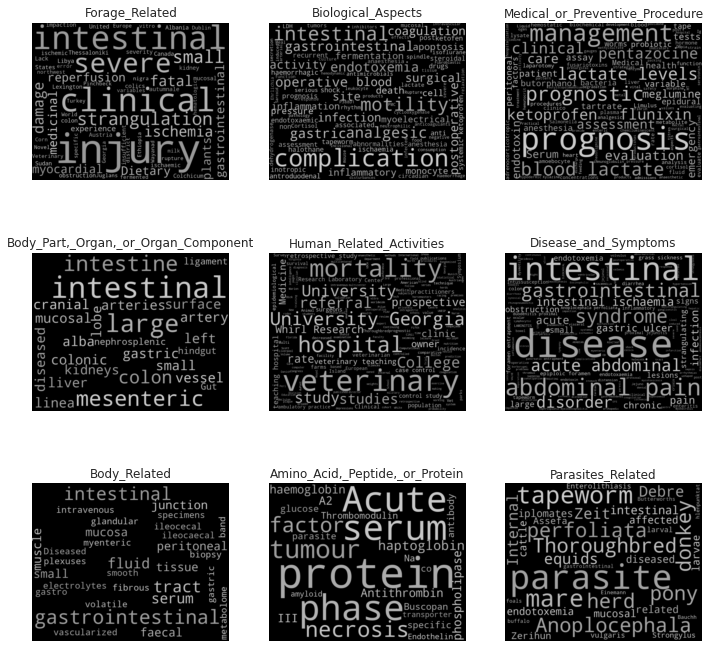

In [112]:
fig = plt.figure(figsize=(12,12))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    wc = entityWordCloud(keys_pd.text[i],stopwords,1000,800,0)
    # display the fitted and recolored wordcloud
    ax.imshow(wc.recolor(color_func=grey_color_func, random_state=42), 
               interpolation="bilinear")
    plt.title(keys_pd.label[i])
    ax.axis('off')
    